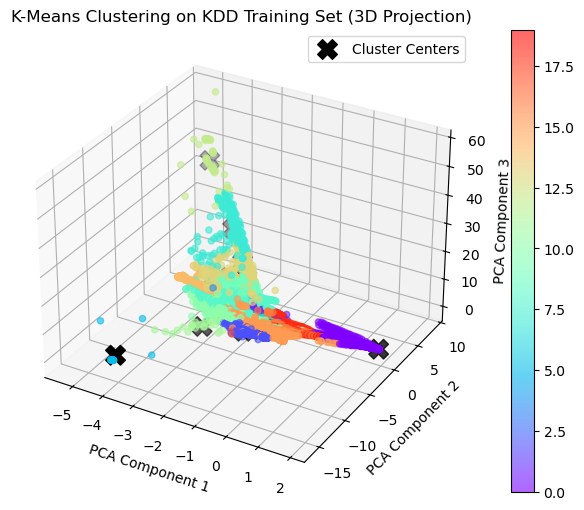

cluster
0     280729
19     48400
3      38402
6      28513
2      25283
1      22064
10     13884
17     10797
18      8266
16      4456
15      4145
9       2926
8       2707
14      2189
13       694
7        420
12        47
11        28
5         18
4          1
Name: count, dtype: int64
Lower Bound 403.0675
Upper Bound 178571.5
Detected Anomalous Clusters: [0, 12, 11, 5, 4]


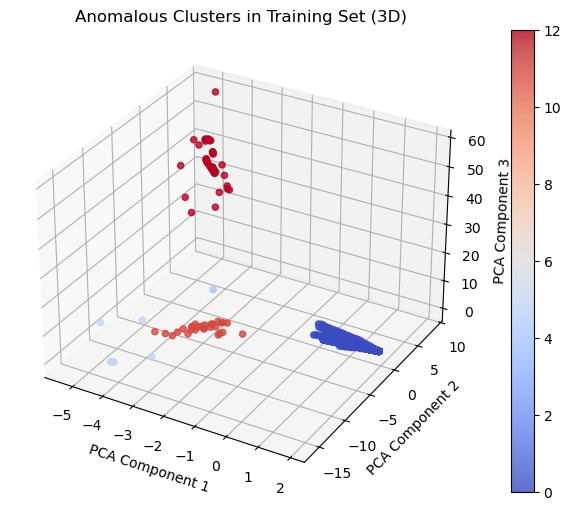


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    391458
           1       0.94      0.98      0.96     97278
           2       0.94      0.51      0.67      4107
           3       0.83      0.01      0.03      1126

    accuracy                           0.98    493969
   macro avg       0.93      0.63      0.66    493969
weighted avg       0.98      0.98      0.98    493969



In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import joblib
from common_stage import prepareData

# Features to be dropped
dropped_features = [
    "srv_serror_rate", "serror_rate",
    "dst_host_srv_serror_rate", "srv_rerror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "dst_host_same_srv_rate",
    "land", "wrong_fragment",
    "urgent", "diff_srv_rate", "same_srv_rate",
    "srv_diff_host_rate", "dst_host_srv_diff_host_rate",
    "rerror_rate"
]

# Load and preprocess data
x_train, y_train, x_test, y_test = prepareData(scaling='standard', removed_features=dropped_features)

# Apply K-Means Clustering to training set
kmeans = KMeans(n_clusters=20, random_state=42).fit(x_train)
x_train['cluster'] = kmeans.labels_

# Reduce to 3D using PCA (fit only on training set)
pca = PCA(n_components=3)
X_pca_train = pca.fit_transform(x_train.drop(columns=['cluster']))

# Transform cluster centers with correct feature names
centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=x_train.drop(columns=['cluster']).columns)
centers_pca = pca.transform(centers_df)

# Plot Clusters in 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_train[:, 0], X_pca_train[:, 1], X_pca_train[:, 2], c=x_train['cluster'], cmap='rainbow', alpha=0.6)
ax.scatter(centers_pca[:, 0], centers_pca[:, 1], centers_pca[:, 2], c='black', marker='X', s=200, label='Cluster Centers')
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("K-Means Clustering on KDD Training Set (3D)")
plt.legend()
plt.colorbar(scatter)
plt.show()

# Identify anomalous clusters
cluster_sizes = x_train['cluster'].value_counts()
Q1 = np.percentile(cluster_sizes, 25)
Q3 = np.percentile(cluster_sizes, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 0.01 * IQR
upper_bound = Q3 + 7.0 * IQR
anomalous_clusters = cluster_sizes[(cluster_sizes < lower_bound) | (cluster_sizes > upper_bound)].index.tolist()

print(x_train['cluster'].value_counts())
print("Lower Bound", lower_bound)
print("Upper Bound", upper_bound)
print("Detected Anomalous Clusters:", anomalous_clusters)

# Mark anomalies
x_train['anomaly'] = x_train['cluster'].apply(lambda c: 1 if c in anomalous_clusters else 0)

# 3D plot of anomalous clusters only
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
anomaly_mask = x_train['anomaly'] == 1
anomaly_pca = X_pca_train[anomaly_mask]
anomaly_clusters = x_train['cluster'][anomaly_mask]
anomaly_plot = ax.scatter(anomaly_pca[:, 0], anomaly_pca[:, 1], anomaly_pca[:, 2], c=anomaly_clusters, cmap='coolwarm', alpha=0.8)
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("Anomalous Clusters in Training Set (3D)")
plt.colorbar(anomaly_plot)
plt.show()

# Evaluation by attack type
y_true = y_train.reset_index(drop=True)
y_pred_clusters = x_train['cluster']

# Map each cluster to its most frequent true label
cluster_to_label = {}
mapped_preds = []
for cluster in y_pred_clusters.unique():
    indices = y_pred_clusters[y_pred_clusters == cluster].index
    majority_label = y_true.loc[indices].value_counts().idxmax()
    cluster_to_label[cluster] = majority_label

# Create mapped prediction list
mapped_preds = y_pred_clusters.map(cluster_to_label)

# Ensure types match for classification report
y_true = y_true.astype(str)
mapped_preds = mapped_preds.astype(str)

# Show classification report
print("\nClassification Report:")
print(classification_report(y_true, mapped_preds, zero_division=0))